In [26]:
import universe
reload(universe)
from universe import *

import mass_function
reload(mass_function)
from mass_function import *

import sfr
reload(sfr)
from sfr import *

import profile
reload(profile)
from profile import *

import i_halo_model
reload(i_halo_model)
from i_halo_model import *

import pn_3d
reload(pn_3d)
from pn_3d import *

In [27]:
from IPython.display import Image

In [28]:
# Basic functions and parameters, for background and fluctuations
u = UnivPlanck15()

In [29]:
# Several mass functions implemented: Press-Schechter, Sheth-Tormen, Tinker
#massFunc = MassFuncPS(u, save=False)
massFunc = MassFuncST(u, save=False)
#massFunc = MassFuncTinker(u, save=False)

Loading mass function and biases


Implementing the $SFR(m, z)$ relation from Fonseca+16

In [30]:
sfr = Sfr(u, massFunc)

Just a test that I recover their figure (it works)

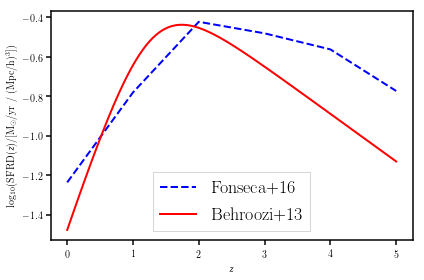

In [31]:
sfr.testSfrd()

This is where I basically implemented our CLF ansatz, with values read from the EGG simulated catalog.
Here and below I am focusing on Halpha, but the others are all implemented.

In [32]:
profLIM = ProfLIM(u, sfr, lineName='halpha', trunc=4.)

Loading non-lin mass at z=0


(ignore this plot, just a test for me)

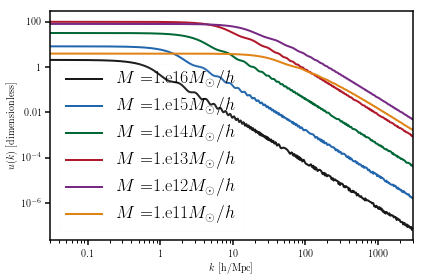

In [33]:
profLIM.plotU(z=1.)

This is the $N_\text{gal}(m,z)$ in our ansatz in the overleaf. I don't have a good intuition for what to expect here, but the integral over mass, multiplied by the halo mass function, gives by construction the number density of galaxies measured in EGG.

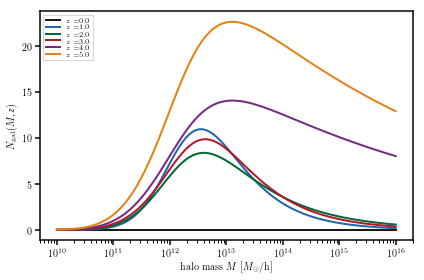

In [34]:
profLIM.plotNgal()

Number density of galaxies, as measured from EGG. I don't have a good intuition whether the order of magnitudes make sense here.

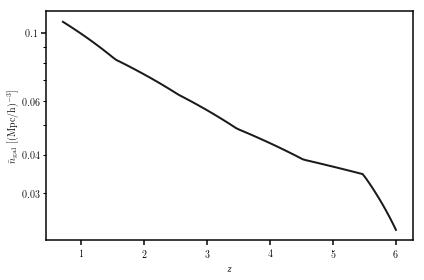

In [35]:
profLIM.plotnGal()

# Mean intensity

Mean intensity. A plot to be compared with Fig 3 in Gong Cooray+2017. The shape matches, but somehow I am off by 7 orders of magnitude!!!
However, this quantity does not enter the power spectrum plots below, because I am showing the power spectrum of $\delta I / I$ and not $\delta I$.
But I need to figure out what is happening here.

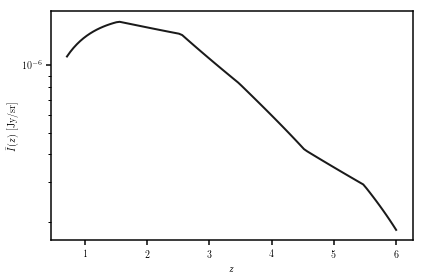

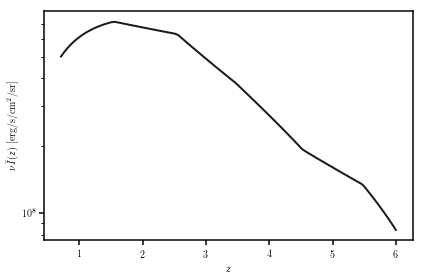

In [36]:
profLIM.plotMeanIntensity()

My result is way too small (1e-6 VS 10) compared to Gong+17 fig 3.

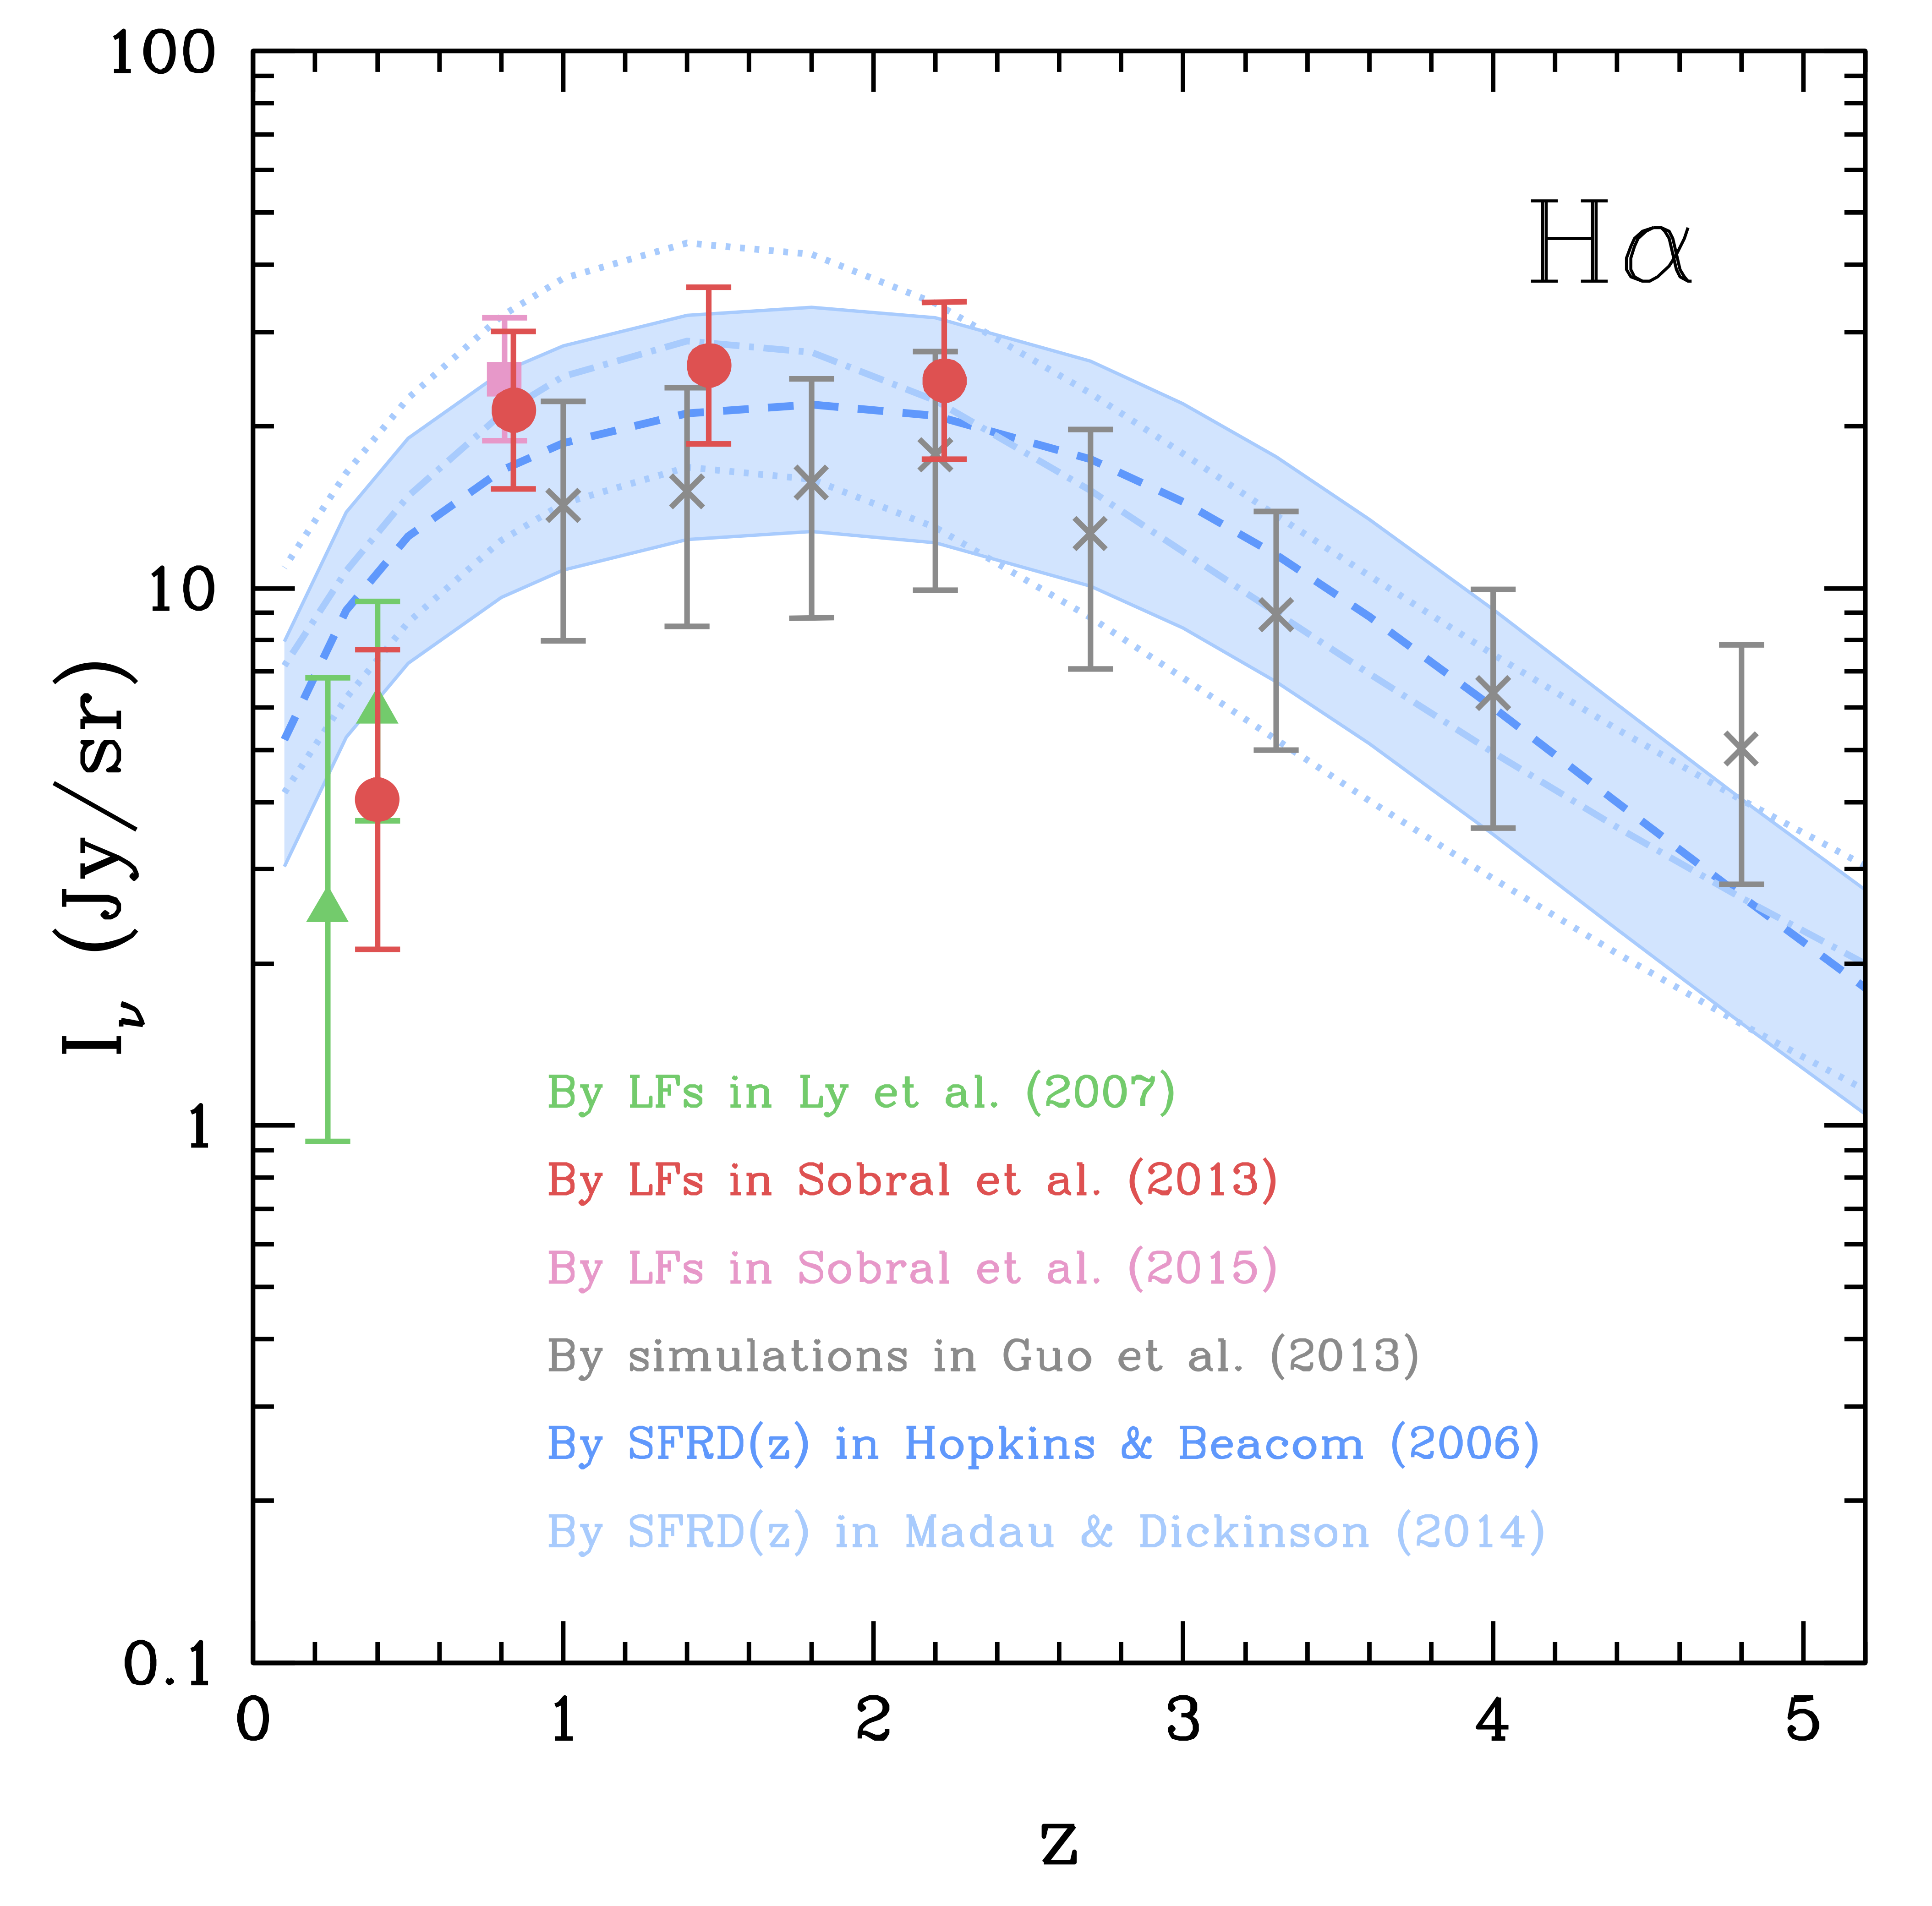

In [37]:
Image("./input/EGG_results/tests/Gong+17_fig3.png")

But my result is way too large (1.e8 vs 1.e-8) compared to Fonseca+16 fig 3.

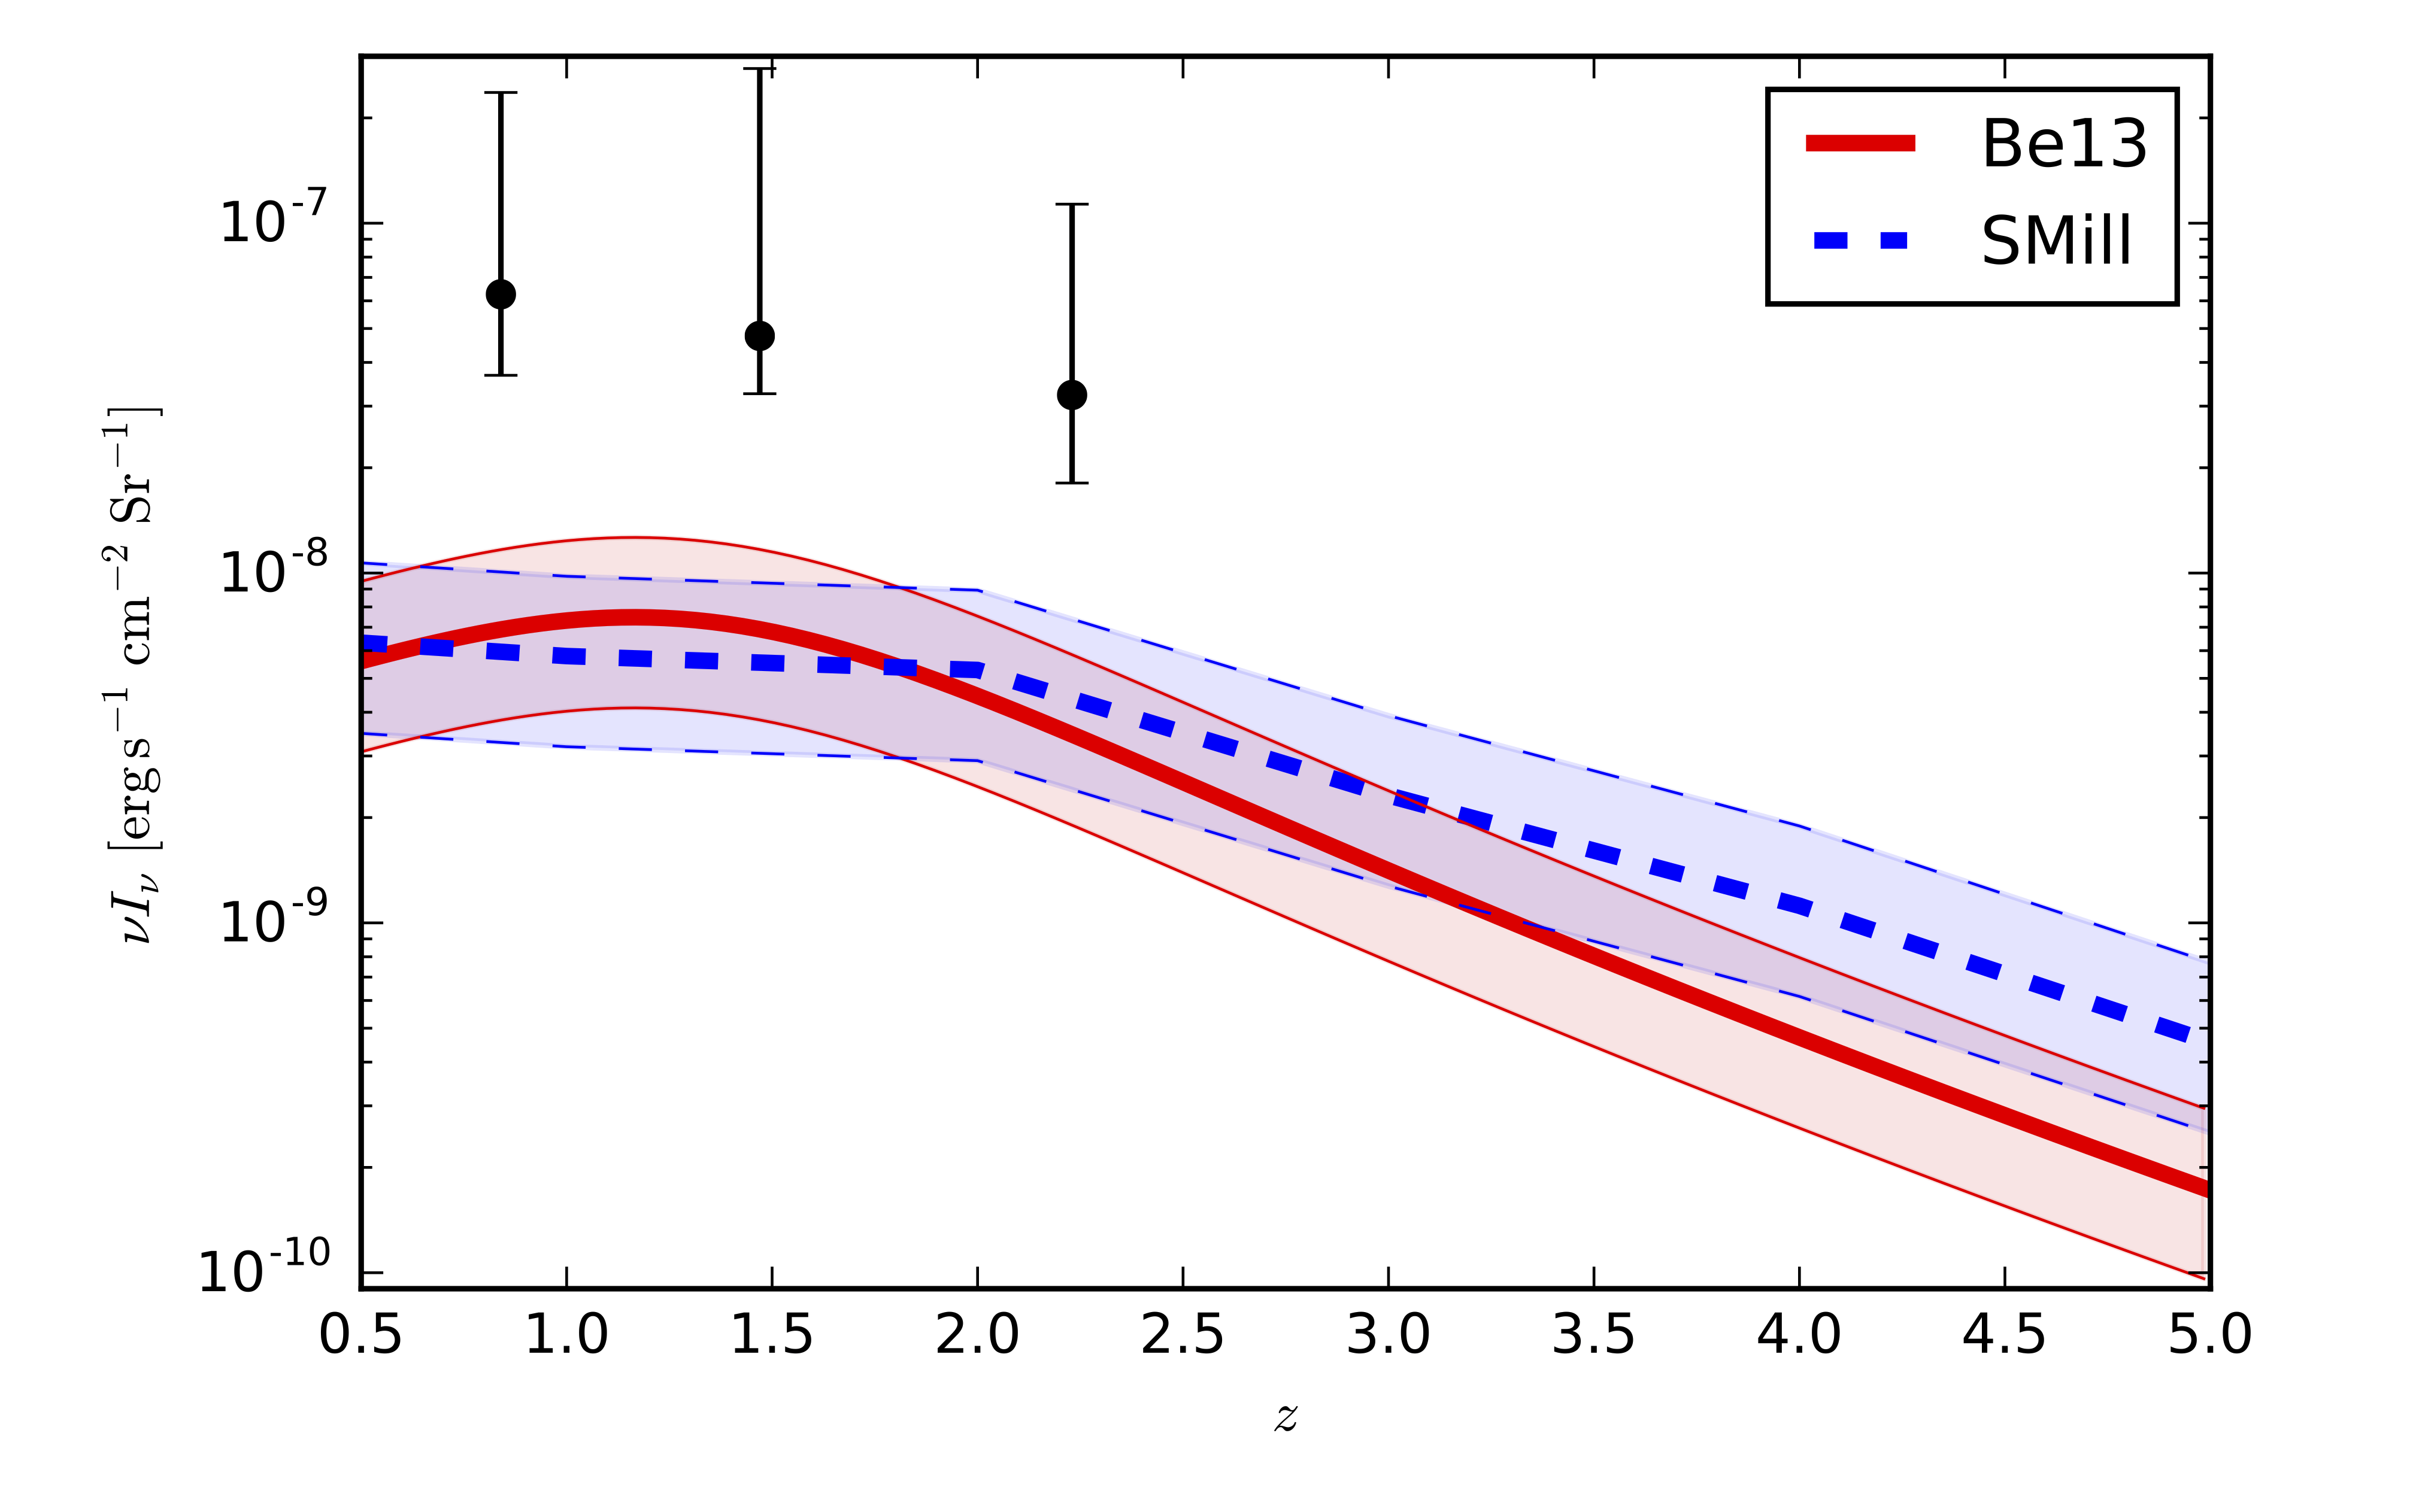

In [45]:
Image("./input/EGG_results/tests/Fonseca+16_fig3.png")

This is how I do my unit conversions... I can't see anything obviously wrong:

In [ ]:
   def meanIntensity(self, z, unit='SI'):
      '''Mean intensity in [Lsun / (Mpc/h)^2 / sr / Hz]
      '''
      result = self.meanLumDensity(z)  # [Lsun / (Mpc/h)^3]
      result *= 3.e5 / self.U.hubble(z)   # *[Mpc/h]
      result /= 4. * np.pi * self.nuHz # *[/sr/Hz]
        
      if unit=='Jy/sr':
         result *= 3.827e26   # [Lsun] to [W]
         result /= (3.086e22 / self.U.bg.h)**2  # [(Mpc/h)^{-2}] to [m^{-2}]
         result /= 1.e-26  # [W/m^2/Hz/sr] to [Jy/sr]
      
      elif unit=='cgs':
         result *= 3.839e33  # [Lsun] to [erg/s]
         result /= (3.086e24 / self.U.bg.h)**2  # [(Mpc/h)^{-2}] to [cm^{-2}]
        
      return result



# Halo model power spectrum

In [39]:
# halo model integrals
iHaloModel = IHaloModel(u, massFunc)

Computing the auto-spectrum for Halpha, without RSD for now.
Here, for the shot noise, I put what we have in the overleaf, ie the effective number density of galaxies, which takes into account the variance in the line luminosity.
I get a large shot noise, larger than the 1-halo term. To be checked. This is probably not mathematically impossible, even though there are fewer halos than galaxies, because the scatter in luminosities enters the shot noise and not the 1-halo term.
If true, the 1-halo term is never dominant.

In [40]:
p3d_lim = P3dAuto(u, iHaloModel, profLIM, fPnoise = lambda k,z: profLIM.Pshot(z), doT=False, save=False)
#p3d_lim = P3dAuto(u, iHaloModel, profLIM, fPnoise = lambda k,z: 1./profLIM.nGal(z), doT=False, save=False)
#p3d_limlim = P3dCross(u, iHaloModel, profLIM, profLIM, doT=False, save=False)

Here the y axis is in (Mpc/h)$^3$.

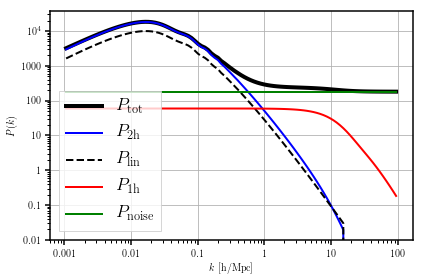

In [41]:
p3d_lim.plotP(z=1.)

This is the effective bias for the 2-halo term. With our CLF ansatz, it simplifies at low $k$ to:
$\int dm n(m) b(m) SFR(m) / \int dm n(m) SFR(m)$,
ie the SFR-weighted halo bias.

Here I removed the "correction" that people apply to the bias from the fact that the consistency relation
$\int dm n(m) b(m) m = \rho_m$
is not satisfied in practice (would require extremely low masses in the integral).
This is customarily done for the matter power spectrum / lensing power spectrum.

When the correction factor is applied, the bias shoots up at high z, to values about 25 at $z=5$.

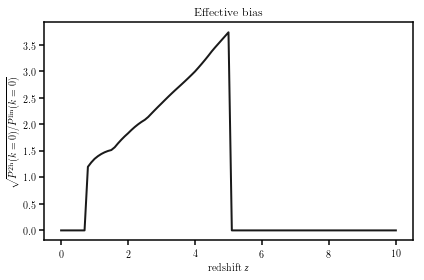

In [42]:
p3d_lim.plotBEff()

This is what I get if the shot noise is $1/\bar{n}_\text{gal}$, without taking into account the scatter in line luminosities. There the shot noise is much smaller, and only matters on very very small scales.

In [43]:
p3d_lim = P3dAuto(u, iHaloModel, profLIM, fPnoise = lambda k,z: 1./profLIM.nGal(z), doT=False, save=False)

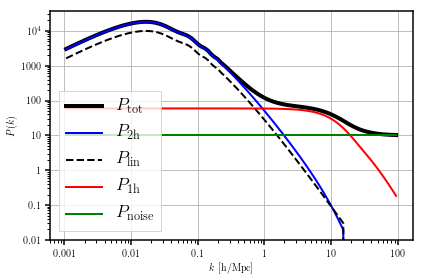

In [44]:
p3d_lim.plotP(z=1.)